In [1]:
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from ops import linear

In [2]:
sess = tf.InteractiveSession()

In [3]:
batch_size = 100

# The number of dimensions of noise to give the generator.
input_size = 1
output_size = 2
# The data we're trying to fit
data = [[math.cos(x/500)+(np.random.uniform()-0.5)/5, math.sin(x/500)+(np.random.uniform()-0.5)/5] for x in range(-2000, 2000)]
# data = [[x, math.sin(x*5)+(np.random.uniform()-0.5)/5] for x in np.arange(-1,1,.0005)]

In [4]:
z = tf.placeholder(tf.float32, [None, input_size], name='z')
layer_input = z
stddev = 0.5
for i, layer_size in enumerate([16, 16]):
    output = tf.nn.relu(linear(layer_input, layer_size, scope="g_{0}".format(i), stddev=stddev))
    layer_input = output
g_output = linear(layer_input, output_size, scope="g_final", stddev=stddev)

In [5]:
""" 
Create two discriminators reusing the variables for each but 
different inputs and outputs. The reason for this is as follows:
We want to allow gradients to flow from the discriminator output
back to the generator in order for the generator to get a signal 
of how to do better. Hence we'd like the g_output to be an input
to D. Additionally we need to be able to feed D examples generated 
from the true distribution, i.e. its input should be a placeholder, 
which takes in values (numbers) rather than nodes (variables). We 
can't use placeholders for parameters that need to be learned, 
hence there are two separate inputs to D with two outputs, but only 
one D.
"""
discriminator_layers = [16, 16]
layer_input = tf.placeholder(tf.float32, [None, output_size], name='real_data')
real_data_input = layer_input
for i, layer_size in enumerate(discriminator_layers):
    output = tf.nn.relu(linear(layer_input, layer_size, scope="d_{0}".format(i)))
    layer_input = output
d_output_real = linear(layer_input, 1, scope="d_final")
# Discriminator that takes real data
tf.get_variable_scope().reuse_variables()
layer_input = g_output
for i, layer_size in enumerate(discriminator_layers):
    # This looks up the variable with tf.get_variable, allowing reuse
    output = tf.nn.relu(linear(layer_input, layer_size, scope="d_{0}".format(i)))
    layer_input = output
# This doesn't use get_variable and is new.
d_output_fake = linear(layer_input, 1, scope="d_final")

In [6]:
# Now we define two discriminator losses, based on the fake and real discriminator predictions.
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(d_output_real, tf.ones_like(d_output_real)))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(d_output_fake, tf.zeros_like(d_output_fake)))
d_loss = tf.add(d_loss_real, d_loss_fake)
# And the generator loss
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(d_output_fake, tf.ones_like(d_output_fake)))

In [7]:
t_vars = tf.trainable_variables()
d_vars = [var for var in t_vars if 'd_' in var.name]
g_vars = [var for var in t_vars if 'g_' in var.name]

d_optim = tf.train.AdamOptimizer(0.01, beta1=0.5).minimize(d_loss, var_list=d_vars)
g_optim = tf.train.AdamOptimizer(0.0005, beta1=0.5).minimize(g_loss, var_list=g_vars)
tf.initialize_all_variables().run()

<IPython.core.display.Javascript object>


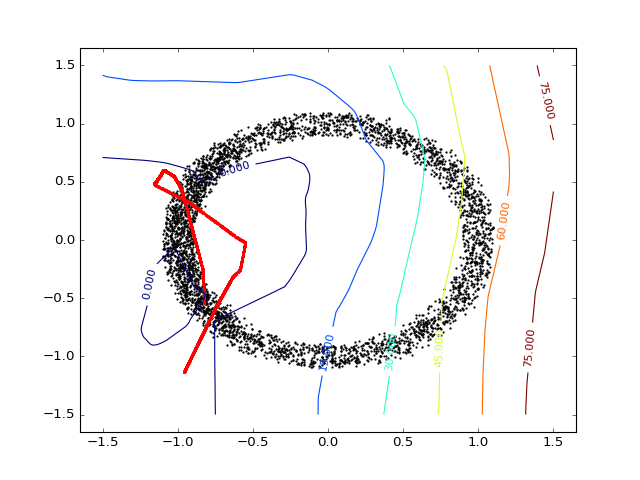

loss 0.274333 0.272201 1.50031
loss 0.166312 0.130152 2.317
loss 0.242013 0.190785 2.42398
loss 0.418466 0.330606 1.45574


In [ ]:
%matplotlib notebook
import time

fig,ax = plt.subplots(1,1)
counter = 0
np.random.shuffle(data)
z_data = np.random.uniform(-1, 1, [4000, input_size]).astype(np.float32)

# Define these out here since they don't change.
grid = np.mgrid[-1.5:1.5:100j, -1.5:1.5:100j]
pts = np.dstack(grid).reshape(-1, 2)
X, Y = grid

for epoch in range(20):
    batch_idxs = len(data)//batch_size
    for idx in range(0, batch_idxs):
        if idx%5==0:
            ax.clear()
            ax.scatter([g[0] for g in data], [g[1] for g in data], s=1) # True distribution
            gen = g_output.eval({z: z_data})
            ax.scatter([g[0] for g in gen], [g[1] for g in gen], color=[1,0,0,1], s=2) # Generator's embedding

            z_contour = d_output_real.eval({real_data_input: pts})
            CS = ax.contour(X, Y, np.reshape(z_contour, [100, 100]), 8) # Discriminator's predictions
            ax.clabel(CS, inline=1, fontsize=10)

            fig.canvas.draw()
            fig.savefig('videos/test%03d.png' % counter, format='png')
            counter += 1
        
        real_data_batch = np.array(data[idx*batch_size:(idx+1)*batch_size]).astype(np.float32)
        batch_z = np.random.uniform(-1, 1, [batch_size, input_size]).astype(np.float32)
        sess.run([d_optim], feed_dict={ z: batch_z, real_data_input: real_data_batch })
        sess.run([g_optim], feed_dict={ z: batch_z })
    if epoch%2 == 0:
        print("loss", 
              d_loss_real.eval({real_data_input: real_data_batch}), 
              d_loss_fake.eval({z: batch_z}),
              g_loss.eval({z: batch_z}))